
# Proyecto Final — Análisis de Conectividad EEG 
 

### Paula Sofia Pascasio Segovia
#### intenté que sea claro :)


In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.signal import coherence
import scipy.io
import mne
import os
import glob

%matplotlib inline

In [2]:
ruta_base = r"C:\Users\HP\Documents\Paula\UNAM\QUINTO SEMESTRE\Modelos computacionales\Proyecto final"

#esto es para que capte odos los archivos .edf en mi carpeta
archivos_edf = glob.glob(os.path.join(ruta_base, "*.edf"))

print(f"Se encontraron {len(archivos_edf)} archivos para analizar.")
print(archivos_edf[:3]) ###aqui quize que me mostrara los primero 5 para ver si iba bien

Se encontraron 56 archivos para analizar.
['C:\\Users\\HP\\Documents\\Paula\\UNAM\\QUINTO SEMESTRE\\Modelos computacionales\\Proyecto final\\sub-002_ses-01_task-sentences_eeg.edf', 'C:\\Users\\HP\\Documents\\Paula\\UNAM\\QUINTO SEMESTRE\\Modelos computacionales\\Proyecto final\\sub-003_ses-01_task-sentences_eeg.edf', 'C:\\Users\\HP\\Documents\\Paula\\UNAM\\QUINTO SEMESTRE\\Modelos computacionales\\Proyecto final\\sub-005_ses-01_task-sentences_eeg.edf']


In [3]:
sfreq_target = 256 
fmin, fmax = 8, 13 ####banda alfa (interes en relajacion y atencion basica)

In [4]:
def analizar_sujeto(archivo_path):
    nombre_archivo = os.path.basename(archivo_path)
    print(f"Procesando: {nombre_archivo}...")
    
    # preload=True es importante para poder filtrar
    raw = mne.io.read_raw_edf(archivo_path, preload=True, verbose=False)
    raw.crop(tmin=0, tmax=60) 
    
    ###seleccionar solo canales de eeg porque tenia miedo que hubiera canales ekg 
    raw.pick_types(eeg=True)
    
    ####agrege un preprocesamiento para filtrar
    if raw.info['sfreq'] != sfreq_target:
        raw.resample(sfreq_target)
        
    ###filtro para la banda 1-45Hz
    raw.filter(1., 45., fir_design='firwin', verbose=False)
    
    data_eeg = raw.get_data()
    ch_names = raw.info['ch_names']
    n_channels = len(ch_names)
    
    ####matriz de coherencia espectral
    coh_matrix = np.zeros((n_channels, n_channels))
    
    ###coherecnia entre pares de canales
    for i in range(n_channels):
        for j in range(n_channels):
            ####coherencia
            f, Cxy = coherence(data_eeg[i], data_eeg[j], fs=sfreq_target, nperseg=sfreq_target*2)
            
            ####filtrar de fmin a fmax para sacr banda que me interesa
            mask = (f >= fmin) & (f <= fmax)
            coh_matrix[i, j] = np.mean(Cxy[mask])
            
    ###crear dataframe
    eeg_df = pd.DataFrame(coh_matrix, index=ch_names, columns=ch_names)
    np.fill_diagonal(eeg_df.values, 0) # Diagonal a 0
    
    return eeg_df, ch_names

In [5]:
lista_matrices = []
nombres_sujetos = []

print(f"Iniciando procesamiento de {len(archivos_edf)} sujetos...")

###para sabe ren que numero va
for i, archivo in enumerate(archivos_edf):
    nombre = os.path.basename(archivo)
    print(f"[{i+1}/{len(archivos_edf)}] Procesando: {nombre} ... ", end="")
    
    try:
        df_sujeto, _ = analizar_sujeto(archivo)
        
        ###guardar matriz en lista
        lista_matrices.append(df_sujeto)
        nombres_sujetos.append(nombre)
        print("¡Listo!")
        
    except Exception as e:
        print(f"Error: {e}")

print("\n--- ¡Procesamiento masivo terminado! ---")

Iniciando procesamiento de 56 sujetos...
[1/56] Procesando: sub-002_ses-01_task-sentences_eeg.edf ... Procesando: sub-002_ses-01_task-sentences_eeg.edf...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
¡Listo!
[2/56] Procesando: sub-003_ses-01_task-sentences_eeg.edf ... Procesando: sub-003_ses-01_task-sentences_eeg.edf...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
¡Listo!
[3/56] Procesando: sub-005_ses-01_task-sentences_eeg.edf ... Procesando: sub-005_ses-01_task-sentences_eeg.edf...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
¡Listo!
[4/56] Procesando: sub-006_ses-01_task-sentences_eeg.edf ... Procesando: sub-006_ses-01_task-sentences_eeg.edf...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
¡Listo!
[5/56] Procesando: sub-008_ses-01_task-sentences_eeg.edf ... Procesando: sub-008_ses-01_task-sentences_eeg.edf...
NOTE: pick_types() is a legacy function. New code

Calculando el promedio de 56 sujetos...
Umbral de corte (Top 20%): 0.6061
El HUB principal del grupo es: CB2 (Centralidad: 0.01)
DETALLE DE COMUNIDADES DETECTADAS
Comunidad 1 (Color red): AF3, AF4, C1, C2, C3, C4, C5, C6, CZ, F1, F2, F3, F4, F5, F6, F7, F8, FC1, FC2, FC3, FC4, FC5, FC6, FCZ, FP1, FP2, FPZ, FT7, FT8, FZ, T7, T8
Comunidad 2 (Color blue): CB1, CB2, CP1, CP2, CP3, CP4, CP5, CP6, CPZ, M1, M2, O1, O2, OZ, P1, P2, P3, P4, P5, P6, P7, P8, PO3, PO4, PO5, PO6, PO7, PO8, POZ, PZ, TP7, TP8
Comunidad 3 (Color green): EKG, EMG
Comunidad 4 (Color orange): HEO
Comunidad 5 (Color purple): VEO


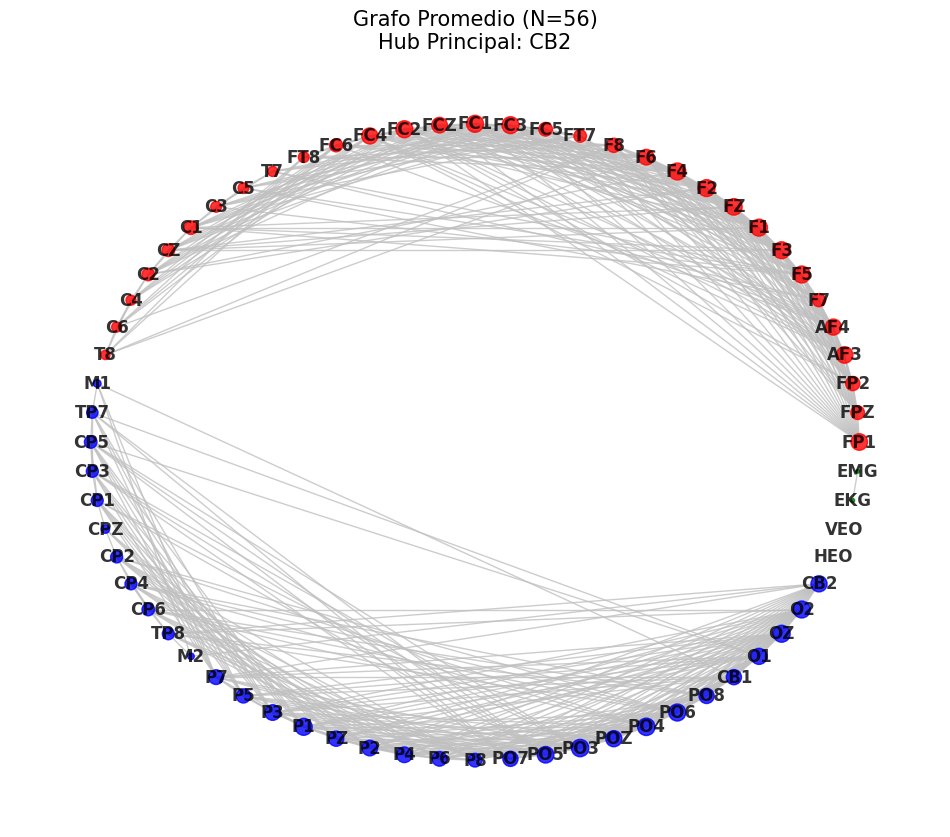

In [13]:
if 'lista_matrices' in locals() and len(lista_matrices) > 0:
    print(f"Calculando el promedio de {len(lista_matrices)} sujetos...")
    

    matriz_promedio = sum(lista_matrices) / len(lista_matrices)
        
    ###definir umbral
    ####solo me voya a quedar con el 20% de conexiones fuertes
    data_values = matriz_promedio.values.flatten()
    threshold = np.percentile(data_values, 80) 
    print(f"Umbral de corte (Top 20%): {threshold:.4f}")

    ###crear un grafo filtrado
    df_filtered = matriz_promedio.where(matriz_promedio > threshold, 0)
    G_promedio = nx.from_pandas_adjacency(df_filtered, create_using=nx.Graph())

    from networkx.algorithms import community
    
    ###comunidades
    communities = community.greedy_modularity_communities(G_promedio)
    
    ###hubs 
    betweenness = nx.betweenness_centrality(G_promedio)
    hub_principal = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[0]
    
    print(f"El HUB principal del grupo es: {hub_principal[0]} (Centralidad: {hub_principal[1]:.2f})")

    colores = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta']
    
    print("DETALLE DE COMUNIDADES DETECTADAS")
    for i, comunidad in enumerate(communities):
        ###hay que convertirlo a lista ordenada
        nodos_en_comunidad = sorted(list(comunidad))

        color_asignado = colores[i % len(colores)]
        
        print(f"Comunidad {i+1} (Color {color_asignado}): {', '.join(nodos_en_comunidad)}")
    plt.figure(figsize=(12, 10))
    
    colores = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta']
    color_map = []
    
    for node in G_promedio.nodes():
        found = False
        for i, comm in enumerate(communities):
            if node in comm:
                color_map.append(colores[i % len(colores)])
                found = True
                break
        if not found:
            color_map.append('gray')

    # ##dibujar grafo
    pos = nx.circular_layout(G_promedio)
    nx.draw_networkx(G_promedio, pos, 
                     node_color=color_map, 
                     node_size=[v * 500 for v in nx.degree_centrality(G_promedio).values()],
                     with_labels=True, font_weight='bold', edge_color='silver', alpha=0.8)

    plt.title(f"Grafo Promedio (N={len(lista_matrices)})\nHub Principal: {hub_principal[0]}", fontsize=15)
    plt.axis('off')
    plt.show()

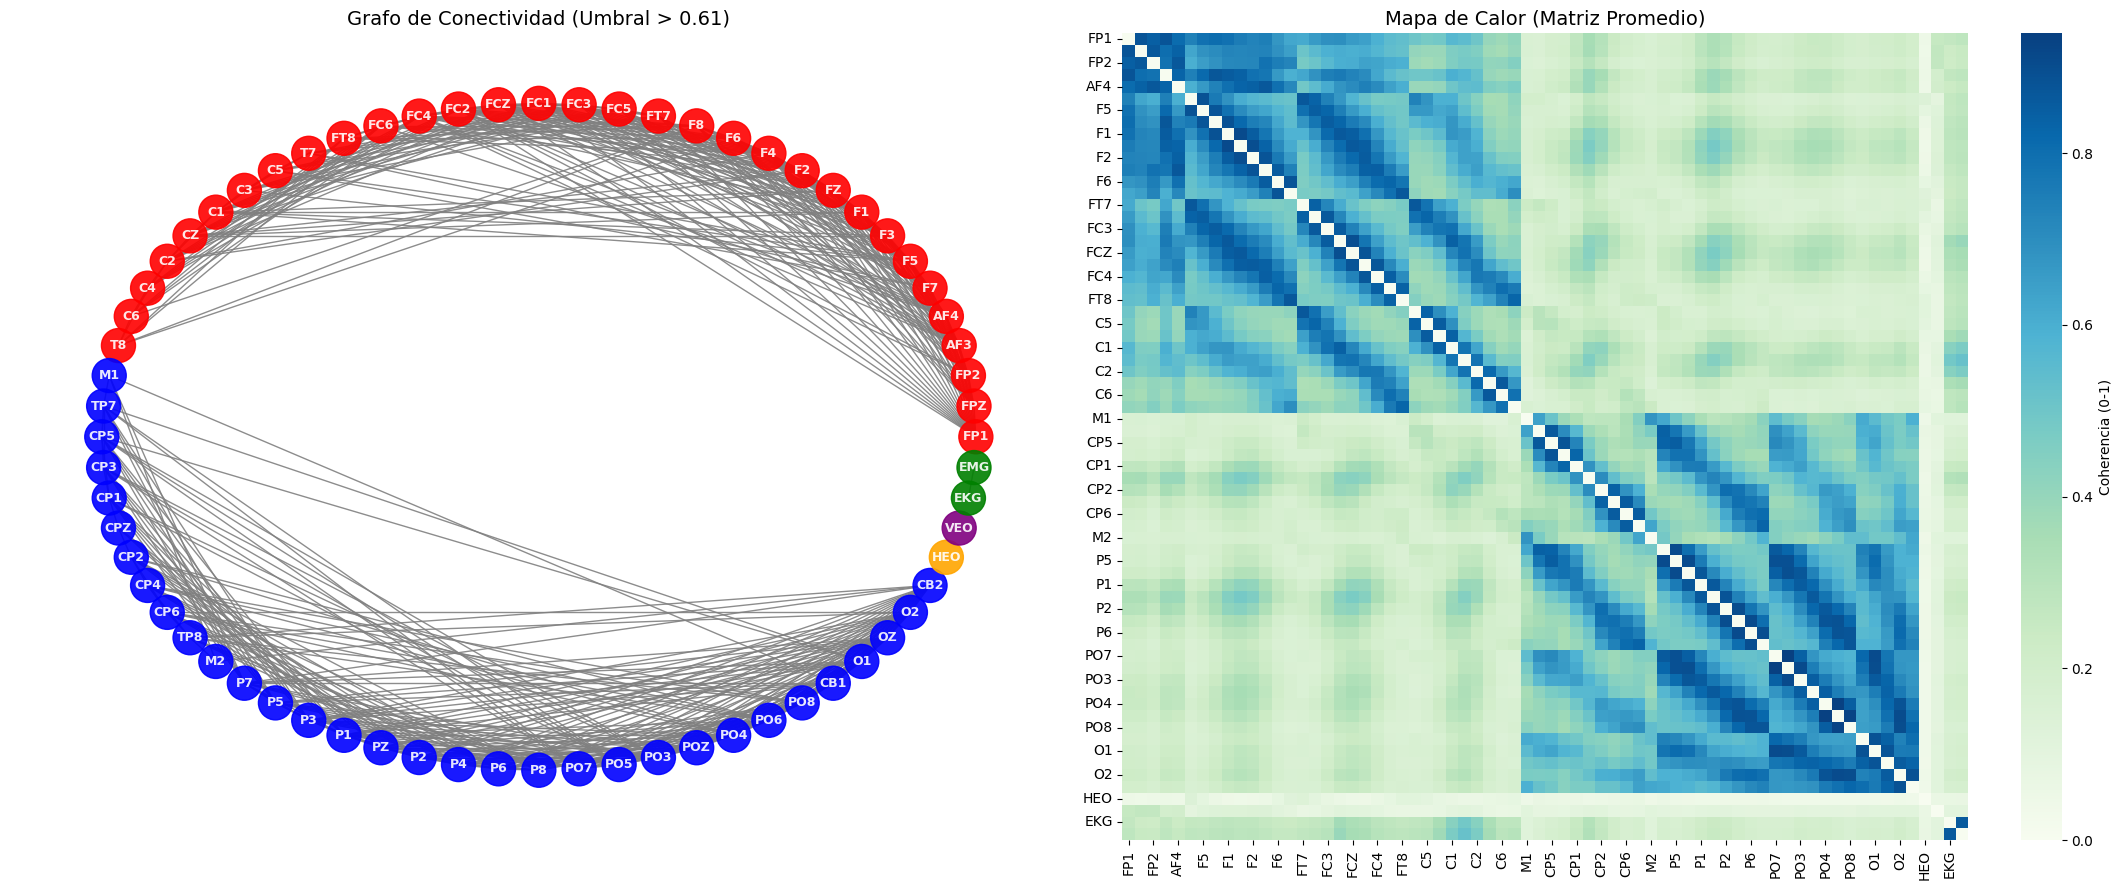

In [11]:
if 'matriz_promedio' in locals():
    fig, axes = plt.subplots(1, 2, figsize=(22, 9))
    
    data_values = matriz_promedio.values.flatten()
    threshold = np.percentile(data_values, 80)
    df_filtered = matriz_promedio.where(matriz_promedio > threshold, 0)
    G_final = nx.from_pandas_adjacency(df_filtered, create_using=nx.Graph())
    
    ###detectar comunidades para ponerle colores bonitos a los nodos
    from networkx.algorithms import community
    communities = community.greedy_modularity_communities(G_final)
    colores = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow']
    
    color_map = []
    for node in G_final.nodes():
        found = False
        for i, comm in enumerate(communities):
            if node in comm:
                color_map.append(colores[i % len(colores)])
                found = True
                break
        if not found:
            color_map.append('gray')

    ###dibujar el grafo
    pos = nx.circular_layout(G_final) ###diseño circular
    
    axes[0].set_title(f"Grafo de Conectividad (Umbral > {threshold:.2f})", fontsize=14)
    nx.draw_networkx(G_final, pos, ax=axes[0], 
                     node_color=color_map, 
                     node_size=600, 
                     font_color="white", font_weight="bold", font_size=9,
                     edge_color="gray", alpha=0.9)
    axes[0].axis('off') ##quitar bordes feos

    axes[1].set_title("Mapa de Calor (Matriz Promedio)", fontsize=14)
    
    sns.heatmap(matriz_promedio, ax=axes[1], cmap="GnBu", 
                annot=False, ###son muchos numeros pro eso False
                cbar_kws={'label': 'Coherencia (0-1)'})
    
    ###roatr etiquetas para que se vea bien
    axes[1].tick_params(axis='x', rotation=90)
    axes[1].tick_params(axis='y', rotation=0)

    plt.tight_layout()
    plt.show()

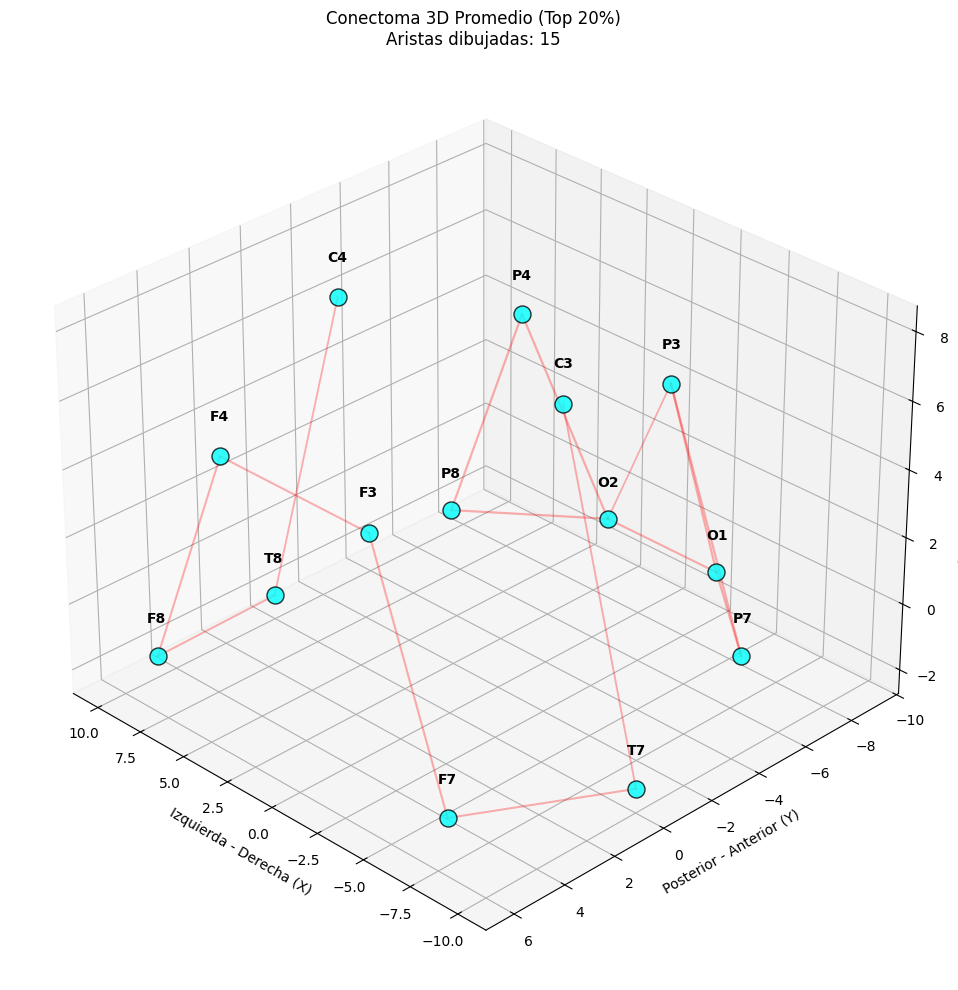

In [10]:
from mpl_toolkits.mplot3d import Axes3D

###Como no tengo coordenadas las voy a poner manualmente
posiciones_1020 = {
    'Fp1': [-3, 9, -1], 'Fp2': [3, 9, -1],
    'F7': [-8, 6, -1], 'F3': [-4, 6, 6], 'Fz': [0, 6, 8], 'F4': [4, 6, 6], 'F8': [8, 6, -1],
    'T7': [-10, 0, -2], 'C3': [-6, 0, 8], 'Cz': [0, 0, 10], 'C4': [6, 0, 8], 'T8': [10, 0, -2],
    'P7': [-8, -6, -1], 'P3': [-4, -6, 6], 'Pz': [0, -6, 8], 'P4': [4, -6, 6], 'P8': [8, -6, -1],
    'O1': [-3, -9, -1], 'O2': [3, -9, -1]
}

if 'matriz_promedio' in locals():
    ###uso el mismso percentil
    data_values = matriz_promedio.values.flatten()
    threshold = np.percentile(data_values, 80)
    
    ###filtrar matriz
    df_3d = matriz_promedio.where(matriz_promedio > threshold, 0)
    G_3d = nx.from_pandas_adjacency(df_3d, create_using=nx.Graph())

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d') # Definir proyección 3D

    ###dibjar nodos
    for nodo in G_3d.nodes():
        nombre_limpio = nodo.replace('.', '')
        
        if nombre_limpio in posiciones_1020:
            x, y, z = posiciones_1020[nombre_limpio]
            
            ###scatter
            ax.scatter(x, y, z, s=150, c='cyan', edgecolors='k', alpha=0.8)
            
            ax.text(x, y, z+1, nodo, fontsize=10, ha='center', fontweight='bold')
    ####aristas
    num_aristas = 0
    for u, v, data in G_3d.edges(data=True):
        weight = data['weight']
        
        u_clean = u.replace('.', '')
        v_clean = v.replace('.', '')
        
        if u_clean in posiciones_1020 and v_clean in posiciones_1020:
            x1, y1, z1 = posiciones_1020[u_clean]
            x2, y2, z2 = posiciones_1020[v_clean]
            
            ax.plot([x1, x2], [y1, y2], [z1, z2], 
                    c='red',                # Color rojo como en el PDF
                    alpha=0.3,              # Transparencia
                    linewidth=weight * 2)   # Grosor proporcional
            num_aristas += 1

    ax.set_xlabel('Izquierda - Derecha (X)')
    ax.set_ylabel('Posterior - Anterior (Y)')
    ax.set_zlabel('Inferior - Superior (Z)')
    ax.set_title(f"Conectoma 3D Promedio (Top 20%)\nAristas dibujadas: {num_aristas}")
    
    ax.view_init(elev=30, azim=135)
    
    plt.tight_layout()
    plt.show()